Travail réalisé par Adrien ANTON LUDWIG et Adèle PLUQUET.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from vega_datasets import data
from cmath import log

In [2]:
import altair as alt
alt.renderers.enable("html")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Scatterplots

On commence par générer un graphique 2D contenant 30000 données, réparties en trois clusters.

In [3]:
from sklearn.datasets import make_blobs
import scipy.stats as st

Text(0, 0.5, 'y')

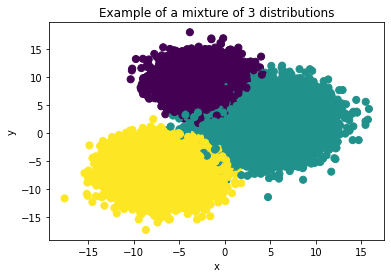

In [4]:
n_components = 3
X, truth = make_blobs(n_samples=30000, centers=n_components, 
                      cluster_std = [2, 3, 2.5], 
                      random_state=42)

plt.scatter(X[:, 0], X[:, 1], s=50, c = truth)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("x")
plt.ylabel("y")

Nous venons d'afficher les données avec **plotly** mais voulons maintenant les afficher avec **Altair**. Pour faire cela, on commence par enregistrer nos données dans un dataframe Pandas.

In [5]:
df = pd.DataFrame(X, columns=["x", "y"])
df["label"] = truth
df.head()

x          y  label
0  -3.160106   9.805896      0
1 -10.015740  -5.476971      2
2  -0.880518  15.008683      0
3   0.180173  10.316948      0
4   4.613911   0.496252      1

In [6]:
alt.Chart(df).mark_point().encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
    alt.Color('label:N')
)

alt.Chart(...)

Dans les deux cas, nous constatons que la quantité de données et leur répartition empêche une bonne lecture du graphique. On ne peut par exemple pas voir la répartition des valeurs au sein de chaque cluster. Voici plusieurs moyens qui permettent de représenter ces nuages de points de manière plus adaptée.

Tout d'abord, nous allons créer une meshgrid de 150 par 150 qui encadrera toutes nos valeurs. Cette meshgrid va permettre d'obtenir davantage d'informations sur la répartition de nos points grâce à un noyau gaussien.

In [7]:
x = X[:, 0]
y = X[:, 1]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:150j, ymin:ymax:150j]

-20.962253003505175 19.16752722270156 -20.799134178476137 21.497144521952197


In [8]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

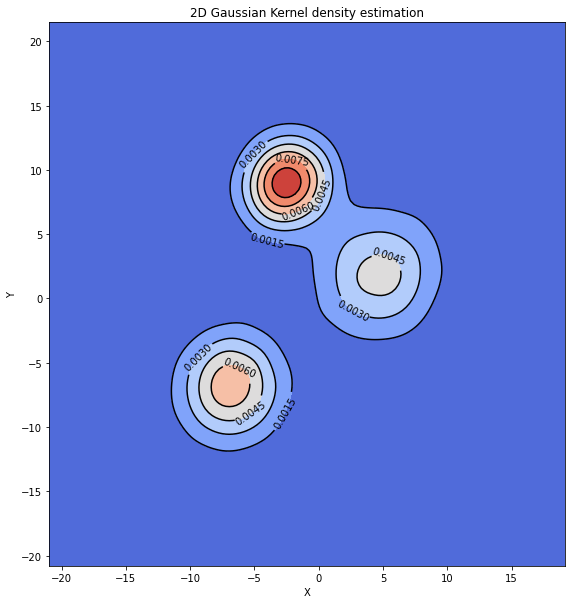

In [9]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

Avec cette représentation, on arrive déjà mieux à visualiser la densité de points. Les valeurs des arcs et les couleurs (du plus clair au plus foncé), nous permettent de visualiser assez facilement la répartition de la densité. La méthode ci dessous permet d'être encore plus précis. On retrouve d'ailleurs les informations de la représentation précédente avec le cluster de label 0 étant celui ayant la densité la plus élevée. Cette seconde représentation est en plus, interactive en faisant passer notre souris dessus !

In [10]:
fig = px.density_contour(
    df, x='x', y='y',
    marginal_x='histogram', marginal_y='histogram',
    color='label',
    width = 1000, height = 600
)
fig.show()

On a jusqu'ici utilisé des représentations 2D mais une représentation en 3D est encore plus adéquate car elle permet de visualiser notre cas intantanément !

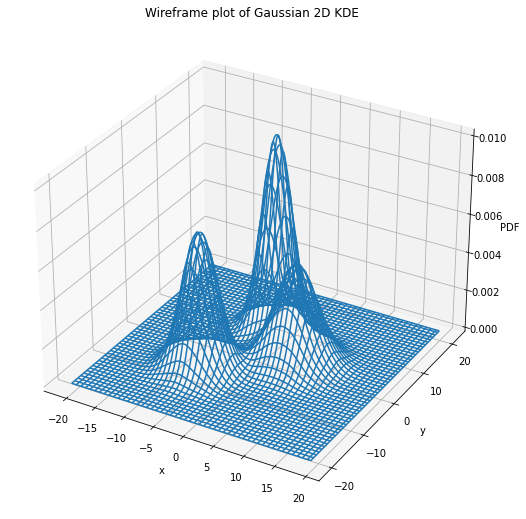

In [11]:
fig = plt.figure(figsize=(15, 9))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(xx, yy, f)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Gaussian 2D KDE');

#

# Overplotting Pie Charts

Qu'en est-il maintenant pour les diagrammes camembert ? 

In [12]:
population = pd.read_json('data/population.json')
population.shape

(244, 2)

In [13]:
population.head()

country  population
0     Afghanistan    37172386
1         Albania     2866376
2         Algeria    42228429
3  American Samoa       55465
4         Andorra       77006

In [14]:
import plotly.express as px
fig = px.pie(population, values='population', names='country',
             title='Population of American continent',
             hover_data=['population'], labels={'lifeExp':'life expectancy'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

On se rend bien compte que ce diagramme camembert n'est vraiment pas pratique : On peut lire clairement seulement quelques pays et si l'on cherche un pays en particulier pour connaître sa population, c'est mission presque impossible (la France par exemple).

On fait en effet face à un double problème :
- Il y a trop de classes (de pays)
- L'écart de valeurs entre les pays les plus peuplés et les moins peuplés est trop grand. Les petits pays se font "écraser" par les gros pays.

La forme de diagramme camembert ne semble pas adaptée à notre problème. IL semblerait plus judicieux d'afficher une carte du monde avec la couleur de chaque pays représentant son nombre d'habitants. (Clair = peu d'habitants, Foncé = Beaucoup d'habitants)

In [15]:
df = pd.read_csv("data/2021_population.csv")

In [16]:
df.head()

iso_code        country 2021_last_updated 2020_population             area  \
0      CHN          China     1,447,065,329   1,439,323,776  9,706,961 sq_km   
1      IND          India     1,401,310,563   1,380,004,385  3,287,590 sq_km   
2      USA  United States       334,058,426     331,002,651  9,372,610 sq_km   
3      IDN      Indonesia       278,037,263     273,523,615  1,904,569 sq_km   
4      PAK       Pakistan       227,724,796     220,892,340    881,912 sq_km   

  density_sq_km growth_rate world_%  rank  
0     149/sq_km       0.34%  18.34%     1  
1     424/sq_km       0.97%  17.69%     2  
2      36/sq_km       0.58%   4.23%     3  
3     145/sq_km       1.04%   3.51%     4  
4     255/sq_km       1.95%   2.86%     5

In [17]:
df.replace(',','',regex = True, inplace = True)

df = df.rename(columns = {'world_%':'world'})
df['growth_rate'] = df['growth_rate'].str.strip('%')
df['world'] = df['world'].str.strip('%')
df['density_sq_km'] = df['density_sq_km'].str.strip('/sq_km')

df['2021_last_updated'] = df['2021_last_updated'].astype(np.int64)
df['2020_population'] = df['2020_population'].astype(np.int64)
df['density_sq_km'] = df['density_sq_km'].astype(np.int64)
df['growth_rate'] = df['growth_rate'].astype(float)
df['world'] = df['world'].astype(float)

df['log_pop'] = np.log(df['2020_population'])

In [18]:
df.head()

iso_code        country  2021_last_updated  2020_population           area  \
0      CHN          China         1447065329       1439323776  9706961 sq_km   
1      IND          India         1401310563       1380004385  3287590 sq_km   
2      USA  United States          334058426        331002651  9372610 sq_km   
3      IDN      Indonesia          278037263        273523615  1904569 sq_km   
4      PAK       Pakistan          227724796        220892340   881912 sq_km   

   density_sq_km  growth_rate  world  rank    log_pop  
0            149         0.34  18.34     1  21.087439  
1            424         0.97  17.69     2  21.045353  
2             36         0.58   4.23     3  19.617637  
3            145         1.04   3.51     4  19.426899  
4            255         1.95   2.86     5  19.213186

In [19]:
fig = px.choropleth(df,
                    locations='country',
                    locationmode='country names',
                    color='log_pop',
                    hover_data={'country', '2020_population'},
                    color_continuous_scale='OrRd',
                    labels={"log_pop": "Log of population", "country": "Country", "2020_population":"Population in 2020"}

                    )

fig.update_layout(title='Population par pays en 2020',
                  title_font=dict(size=30, color='DarkSlateBlue'),
                  title_x=0.5,
                  geo=dict(showframe=False,
                           showcoastlines=False,
                           projection_type='natural earth'),
                  width=1000, height=600)

fig.show()


Sur cette carte on voit très clairement les pays avec une forte population et ceux avec un faible population. Grâce à une échelle logarithmique, les petits pays ne sont pas écrasés par les gros pays et possèdent assez de nuances de couleur pour que l'on observe de variations de l'un à l'autre.

# Parallel coordinates

Essayons avec un nouveau modèle d'affichage. Pour cela, nous allons utiliser des données issues du dataset vega sur les automobiles.

In [20]:
import plotly.graph_objects as go

In [21]:
cars = data.cars()
cars.shape

(406, 9)

In [22]:
cars.head()

Name  Miles_per_Gallon  Cylinders  Displacement  \
0  chevrolet chevelle malibu              18.0          8         307.0   
1          buick skylark 320              15.0          8         350.0   
2         plymouth satellite              18.0          8         318.0   
3              amc rebel sst              16.0          8         304.0   
4                ford torino              17.0          8         302.0   

   Horsepower  Weight_in_lbs  Acceleration       Year Origin  
0       130.0           3504          12.0 1970-01-01    USA  
1       165.0           3693          11.5 1970-01-01    USA  
2       150.0           3436          11.0 1970-01-01    USA  
3       150.0           3433          12.0 1970-01-01    USA  
4       140.0           3449          10.5 1970-01-01    USA

Nous avons un dataset composé de 406 lignes et 9 colonnes. Ce dataset concerne des voitures. Il semble intuitif que certaines caractéristiques soient liées. Par exemple, Plus la voiture a de cylindres, plus elle sera puissante et plus elle consommera.

Afin de voir les rapports entre ces différentes caractéristiques, un diagramme en **parallel coordinates** semble adapté. Essayons de visualiser notre donnée comme cela.

In [23]:
fig = px.parallel_coordinates(cars, labels={"Cylinders": "Nb of cylinders",
                "Miles_per_Gallon": "Miles per gallon", "Horsepower": "Horsepower",
                "Weight_in_lbs": "Weight in lbs", "Acceleration": "Acceleration", "Displacement": "Displacement (cylinder volume)"}, dimensions=["Cylinders",
                "Miles_per_Gallon", "Horsepower",
                "Weight_in_lbs", "Displacement","Acceleration"],
                             color_continuous_midpoint=2)
fig.show()

Le diagramme n'est pas bien lisible. On arrive à peu près à comprendre les rapports entre le nombre de cylindres et la consommation, la lecture de l'information devient compliquée après la puissance **(Horsepower)**. Nous pouvons essayer d'afficher cela de manière plus claire.

In [24]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = cars['Cylinders'],
                   colorscale = [[0,'cyan'], [0.25, 'green'], [0.6,'gold'],[1,'red']]),
        dimensions = list([
            dict(
                constraintrange = [2.5,8.5],
                label = 'Nb of cylinders', values = cars['Cylinders']),
            dict(range = [0,50],
                label = 'Miles per gallon', values = cars['Miles_per_Gallon']),
            dict(range = [0,230],
                label = 'Horsepower', values = cars['Horsepower']),
            dict(
                label = 'Acceleration', values = cars['Acceleration']),
            dict(
                label = 'Displacement (cylinder volume)', values = cars['Displacement']),
            dict(
                label = 'Weight in lbs', values = cars['Weight_in_lbs'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

L'utilisation de couleurs, la ré-organisation des axes et l'utilisation de la bonne échelle pour tous les axes (pas de données manquantes comme sur l'axe 'Miles per gallon' et 'Horsepower' du graphique précédent par exemple) permettent une lecture bien meilleure. De plus, il est possible d'intérargir avec le graphique pour sélectionner les données que l'on veut afficher et les mettre alors en surbrillance par rapport aux autres données. On peut combiner plusieurs sélecteurs.

<p align = "center">
<img src="imgs/6-cylinders.png" width="1200" caption="test">
</p>
<p align = "center">
Fig.1 Sélection des véhicules à 6 cylindres
</p>

<p align = "center">
<img src="imgs/10-12-acceleration.png" width="1200" caption="test">
</p>
<p align = "center">
Fig.2 Sélection des véhicules prenant entre 10 et 12.5 secondes environ à atteindre les 100km/h
</p>

<p align = "center">
<img src="imgs/4-cylinders-horsepower.png" width="1200" caption="test">
</p>
<p align = "center">
Fig.3 Sélection des véhicules de 4 cylindres ayant entre 50 et 100 chevaux
</p>